In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/heart-failure-prediction')
else:
    import zipfile,kaggle
    path = Path('heart-failure-prediction')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)


In [2]:

import pandas as pd

# CSV path provided by Kaggle when you add the dataset to your notebook
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")

# Show first few rows
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
modes = df.mode().iloc[0]

In [4]:
cats = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
conts = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
dep = 'HeartDisease'

def proc_data(df):
    df.fillna(modes, inplace=True)

    for i in cats:
        df[i] = pd.Categorical(df[i])

proc_data(df)

In [5]:
df.Sex.cat.codes.head()

0    1
1    0
2    1
3    0
4    1
dtype: int8

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


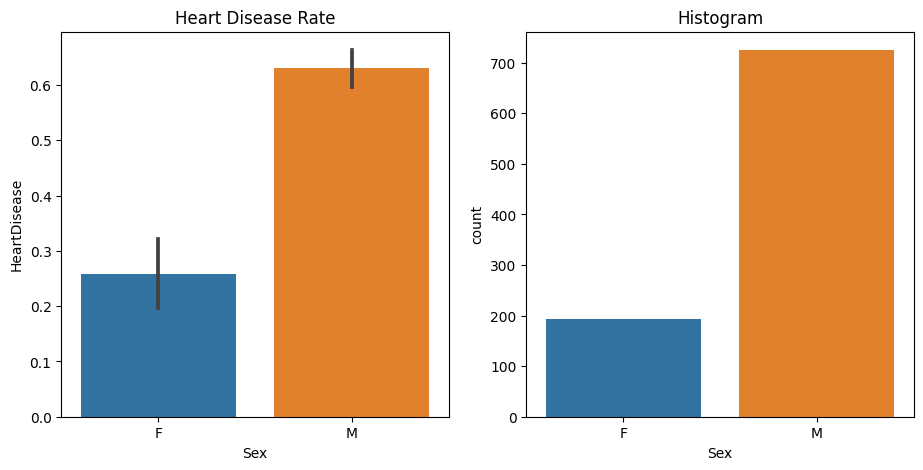

In [6]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Heart Disease Rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

Here we can see that if we make a binary split just based on gender, we would be able to predict heart disease with much better accuracy.

In [7]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

preds = val_xs.Sex==0

from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.6565217391304348

With this model, we achieve an mse of 0.657

Now, let's analyze what a split would look like on a continuous column. For example, take Age:

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


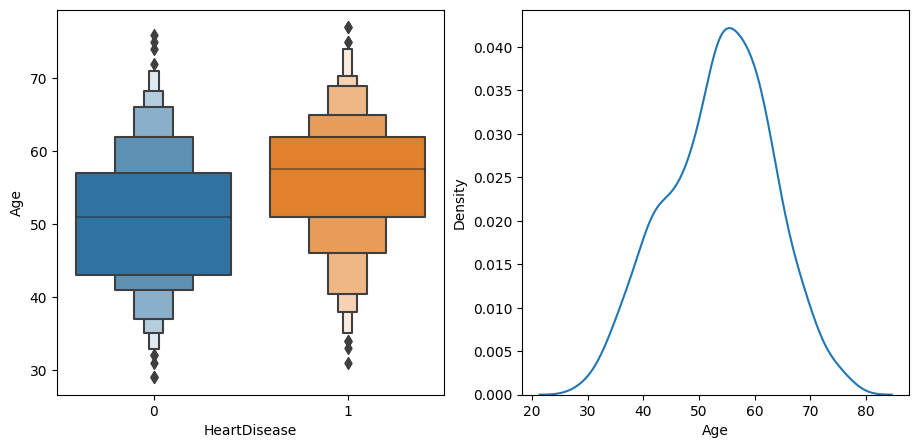

In [8]:
df_fare = trn_df[trn_df.Age>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="Age", ax=axs[0])
sns.kdeplot(data=df_fare, x="Age", ax=axs[1]);

While less accurate then 'sex' binary split, we still achieve an mse of 0.417.

In [9]:
preds = val_xs.Age>52
mean_absolute_error(val_y, preds)

0.41739130434782606